In [207]:
! python -m pip install xgboost
! python -m pip install seaborn
! python -m pip install statsmodels
! python -m pip install lightgbm
! python -m pip install catboost

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [209]:
df1 = pd.read_csv(r"../datasets/kolkata_real_estate_data_20000.csv")
df1.head()

,BEDROOM_NUM,BATHROOM_NUM,PRICE_PER_SQFT,AREA,LOCATION,FURNISH,FACING,AGE,TOTAL_FLOOR,FEATURES,BALCONY_NUM,FLOOR_NUM,CARPET_SQFT,SUPERBUILTUP_SQFT,BUILTUP_SQFT,SUPER_AREA,SUPERAREA_UNIT,SUPER_SQFT
0,NaN,3.0,11500,1978-2008,Ballygunge,NaN,NaN,15.0,6.0,NaN,3.0,1.0,1246,1978,1793-1838,1978,NaN,1978
1,NaN,NaN,7965-8010,2831,Rajarhat,NaN,NaN,NaN,5.0,"Power Backup,Water Supply",0.0,19.0,2072,2831,2364,2831,sqm,2831
2,2.0,3.0,6878,3463,Behala,Furnished,West,16.0,8.0,NaN,2.0,8.0,2192,3463,2853,3463,sq yard,3463
3,3.0,2.0,3875,1216,Howrah,NaN,NaN,9.0,9.0,Reserved Parking,1.0,2.0,776,1216,1142,1216,sq yard,1216
4,5.0,1.0,5247,981,Alipore,NaN,NaN,25.0,NaN,NaN,2.0,NaN,590,981,836,981,NaN,981


In [210]:
df2 = df1.drop(['FURNISH', 'FACING', 'CARPET_SQFT', 'TOTAL_FLOOR', 'FLOOR_NUM', 'FEATURES', 'SUPERBUILTUP_SQFT', 'BUILTUP_SQFT', 'SUPER_AREA', 'SUPERAREA_UNIT', 'SUPER_SQFT'], axis=1)
df2.head()

,BEDROOM_NUM,BATHROOM_NUM,PRICE_PER_SQFT,AREA,LOCATION,AGE,BALCONY_NUM
0,NaN,3.0,11500,1978-2008,Ballygunge,15.0,3.0
1,NaN,NaN,7965-8010,2831,Rajarhat,NaN,0.0
2,2.0,3.0,6878,3463,Behala,16.0,2.0
3,3.0,2.0,3875,1216,Howrah,9.0,1.0
4,5.0,1.0,5247,981,Alipore,25.0,2.0


In [211]:
df2.isnull().sum()

BEDROOM_NUM       3982
BATHROOM_NUM      3919
PRICE_PER_SQFT       0
AREA                 0
LOCATION          4055
AGE               4055
BALCONY_NUM       4094
dtype: int64

In [212]:
# Fill missing values in 'LOCATION' with 'Others'

df2['LOCATION'] = df2['LOCATION'].fillna('Others')
df2['LOCATION'].unique()

array(['Ballygunge', 'Rajarhat', 'Behala', 'Howrah', 'Alipore', 'Garia',
       'Lake Town', 'Park Street', 'Kasba', 'Others', 'Salt Lake',
       'New Town', 'Jadavpur', 'Tollygunge', 'Dum Dum'], dtype=object)

In [213]:
# Fill missing values in Balcony with the mode

df2['BALCONY_NUM'] = df2['BALCONY_NUM'].fillna(df2['BALCONY_NUM'].mode()[0]).astype(int)

In [214]:
# Fill Age of the property with the median 

df2['AGE'] = df2['AGE'].fillna(0).astype(float)
df2['AGE_BUCKET'] = pd.cut(df2.AGE, bins=[-1,5,10,20,30], labels=['New','Mid New','Mid','Old'])
df2.head()

,BEDROOM_NUM,BATHROOM_NUM,PRICE_PER_SQFT,AREA,LOCATION,AGE,BALCONY_NUM,AGE_BUCKET
0,NaN,3.0,11500,1978-2008,Ballygunge,15.0,3,Mid
1,NaN,NaN,7965-8010,2831,Rajarhat,0.0,0,New
2,2.0,3.0,6878,3463,Behala,16.0,2,Mid
3,3.0,2.0,3875,1216,Howrah,9.0,1,Mid New
4,5.0,1.0,5247,981,Alipore,25.0,2,Old


In [215]:
# df2.AGE.describe()

In [216]:
# Fill missing values in 'BEDROOM_NUM' with the mean and convert to integer

df2['BEDROOM_NUM'] = df2['BEDROOM_NUM'].fillna(df2['BEDROOM_NUM'].mean()).astype(float)

In [217]:
# Fill missing values in 'BATHROOM_NUM' with the mean and convert to integer

df2['BATHROOM_NUM'] = df2['BATHROOM_NUM'].fillna(df2['BATHROOM_NUM'].mean()).astype(int)

In [218]:
def return_avg(val):
    if '-' in val:
        low, high = map(float, val.split('-'))
        return (low + high) / 2
    
    return float(val)

In [219]:
# Convert range of area to a single value

df3 = df2.copy()
df3['AREA'] = df3['AREA'].str.split('-')
df3 = df3.explode('AREA').reset_index(drop=True)
df3['AREA'] = df3['AREA'].astype(float)
df3.shape

(21984, 8)

In [220]:
# Convert range of Persqft to a single value
df3['PRICE_PER_SQFT'] = df3['PRICE_PER_SQFT'].str.split('-')
df3 = df3.explode('PRICE_PER_SQFT').reset_index(drop=True)
df3['PRICE_PER_SQFT'] = df3['PRICE_PER_SQFT'].astype(float)
df3.shape

(24161, 8)

In [221]:
df2.isnull().sum()

BEDROOM_NUM       0
BATHROOM_NUM      0
PRICE_PER_SQFT    0
AREA              0
LOCATION          0
AGE               0
BALCONY_NUM       0
AGE_BUCKET        0
dtype: int64

In [222]:
# Adding a new column for total price

df4 = df3.copy()
df4['TOTAL_PRICE'] = df4['AREA'] * df4['PRICE_PER_SQFT'] / 100000
df4 = df4[~((df4['TOTAL_PRICE'] > 500) | (df4['TOTAL_PRICE'] < 10))]
df4.TOTAL_PRICE.describe()

count    23695.000000
mean       182.571059
std        120.424538
min         10.117100
25%         84.155480
50%        153.224370
75%        262.838265
max        499.998030
Name: TOTAL_PRICE, dtype: float64

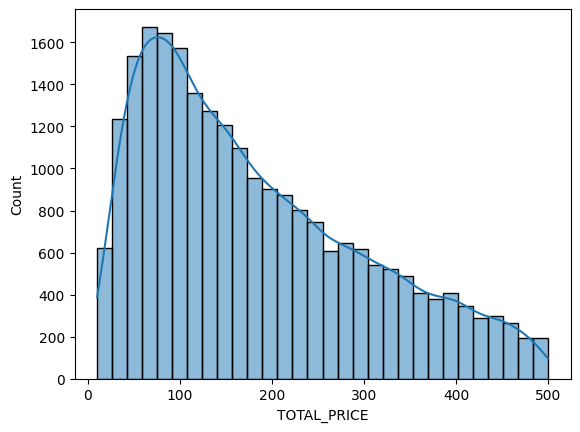

In [223]:
sns.histplot(df4['TOTAL_PRICE'], bins=30, kde=True)

    #plt.xlabel("Area (in sqft)")
    #plt.ylabel("Total Price (in lakhs)")
    #plt.title(f"Price vs Area for {city}")
    #plt.legend()

plt.show()


In [224]:
# Location 

df4['LOCATION'] = df4['LOCATION'].str.strip()
location_count = df4['LOCATION'].value_counts(ascending=False)
location_count

LOCATION
Others         4816
Ballygunge     1417
Park Street    1386
Salt Lake      1380
Dum Dum        1379
Tollygunge     1372
Behala         1355
Lake Town      1349
Howrah         1342
Garia          1341
New Town       1328
Kasba          1324
Jadavpur       1307
Alipore        1304
Rajarhat       1295
Name: count, dtype: int64

In [225]:
df4[['AREA', 'BEDROOM_NUM']].corr()


,AREA,BEDROOM_NUM
AREA,1.000000,-0.004571
BEDROOM_NUM,-0.004571,1.000000


Remove Outliers

In [226]:
# remove outliers

values = [x for x in df4['AREA'] / df4['BEDROOM_NUM'] if x < 300 ]
len(values)

3436

In [227]:
df5 = df4[ ~( (df4['AREA'] / df4['BEDROOM_NUM'] < 300))] #| (df4['AGE'] > 20)) ]
df5.shape

(20259, 9)

In [228]:
# remove outliers as per the BHK Size

def remove_bed_area_outliers(df, bhk, area_upper, area_lower):
   
    df = df[ ~(((df['BEDROOM_NUM'] == bhk ) & ( df['AREA'] > area_upper ) ) | ((df['BEDROOM_NUM'] == bhk) & (df['AREA'] < area_lower))) ]

    return df

# removing any 2 bhk above 2000 sqft 
# df6 = remove_bed_area_outliers(df5, 2, 1800, 600)

# removing any 3 bhk above 2500 sqft
# df6 = remove_bed_area_outliers(df6, 3, 3000, 1000)

# removing any 4 bhk above 4000 sqft
# df6 = remove_bed_area_outliers(df6, 4, 15000, 1500)
df6 = df5.copy()
df6.shape

(20259, 9)

In [229]:
df6.PRICE_PER_SQFT.describe()

count    20259.000000
mean      8397.664692
std       3689.353808
min       2000.000000
25%       5231.000000
50%       8378.000000
75%      11572.500000
max      15022.000000
Name: PRICE_PER_SQFT, dtype: float64

In [230]:
def plot_scatter(df, city):

    bhk2 = df[(df['BEDROOM_NUM'] == 2) & (df['LOCATION'] == city)]
    bhk3 = df[(df['BEDROOM_NUM'] == 3) & (df['LOCATION'] == city)]
    bhk4 = df[(df['BEDROOM_NUM'] == 4) & (df['LOCATION'] == city)]

    plt.figure(figsize = (10,8))

    plt.scatter(bhk2.AREA, bhk2.TOTAL_PRICE, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.AREA, bhk3.TOTAL_PRICE, color='green', label='3 BHK', s=50, marker='x')
    plt.scatter(bhk4.AREA, bhk4.TOTAL_PRICE, color='red', label='4 BHK', s=50, marker='+')

    # sns.histplot(pd.concat([bhk2, bhk3, bhk4])['TOTAL_PRICE'], bins=30, kde=True)

    plt.xlabel("Area (in sqft)")
    plt.ylabel("Price ")
    plt.title(f"Price vs Area for {city}")
    plt.legend()

    plt.show()



In [231]:
def remove_outliers(df):
    df_out = pd.DataFrame()

    for key, subdf in df.groupby('LOCATION'):

        mean = subdf['PRICE_PER_SQFT'].mean()
        std = subdf['PRICE_PER_SQFT'].std()

        q1 = subdf['PRICE_PER_SQFT'].quantile(0.25)
        q3 = subdf['PRICE_PER_SQFT'].quantile(0.75)
        iqr = q3 - q1
                                                     

        reduced_df = subdf[(subdf.PRICE_PER_SQFT >= (q1 - 3 * iqr)) & (subdf.PRICE_PER_SQFT <= (q3 + 3 * iqr))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)

    return df_out

In [232]:
df6.AREA.describe()

count    20259.000000
mean      2423.258256
std        913.593574
min        400.000000
25%       1684.500000
50%       2449.000000
75%       3200.000000
max       4039.000000
Name: AREA, dtype: float64

In [233]:
def remove_area_outliers(df):
    df_out = pd.DataFrame()

    for key, subdf in df.groupby('LOCATION'):

        mean = subdf['AREA'].mean()
        std = subdf['AREA'].std()

        reduced_df = subdf[(subdf.AREA >= (mean - 2 * std)) & (subdf.AREA <= (mean + 2 * std))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)

    return df_out

In [234]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('LOCATION'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('BEDROOM_NUM'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.PRICE_PER_SQFT),
                'std': np.std(bhk_df.PRICE_PER_SQFT),
                'count': bhk_df.shape[0]
            }

        for bhk, bhk_df in location_df.groupby('BEDROOM_NUM'):
            stats = bhk_stats.get(bhk-1)

            if stats and stats['count']>5:
                exclude_indices = np.append(
                    exclude_indices, 
                    bhk_df[bhk_df.PRICE_PER_SQFT < (stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

In [235]:
df7 = remove_bhk_outliers(remove_area_outliers(remove_outliers(df6)))
df7.shape

(13798, 9)

Text(0, 0.5, 'Count')

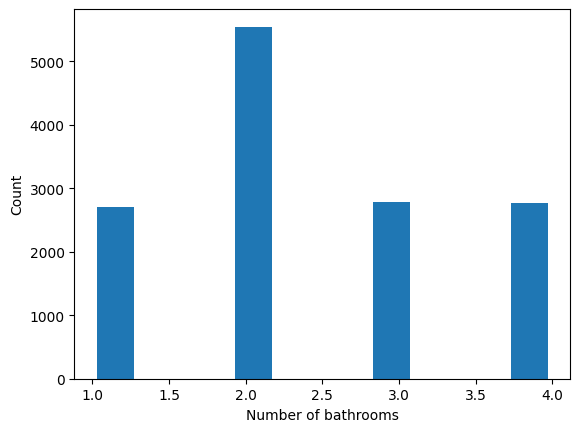

In [236]:
plt.hist(df7.BATHROOM_NUM,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [237]:
df7.BATHROOM_NUM.unique()

array([2, 1, 3, 4])

Text(0, 0.5, 'Count')

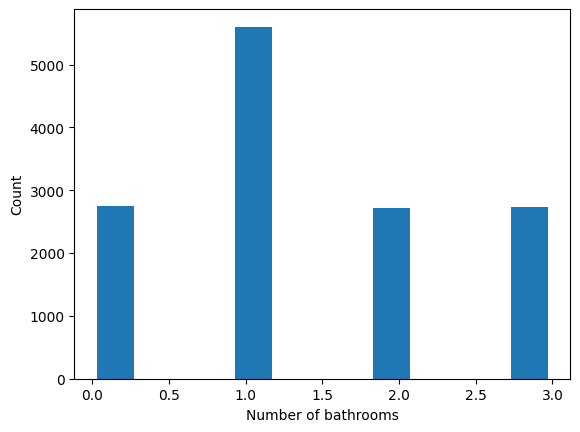

In [238]:
plt.hist(df7.BALCONY_NUM,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [239]:
df7.BALCONY_NUM.unique()

array([1, 3, 2, 0])

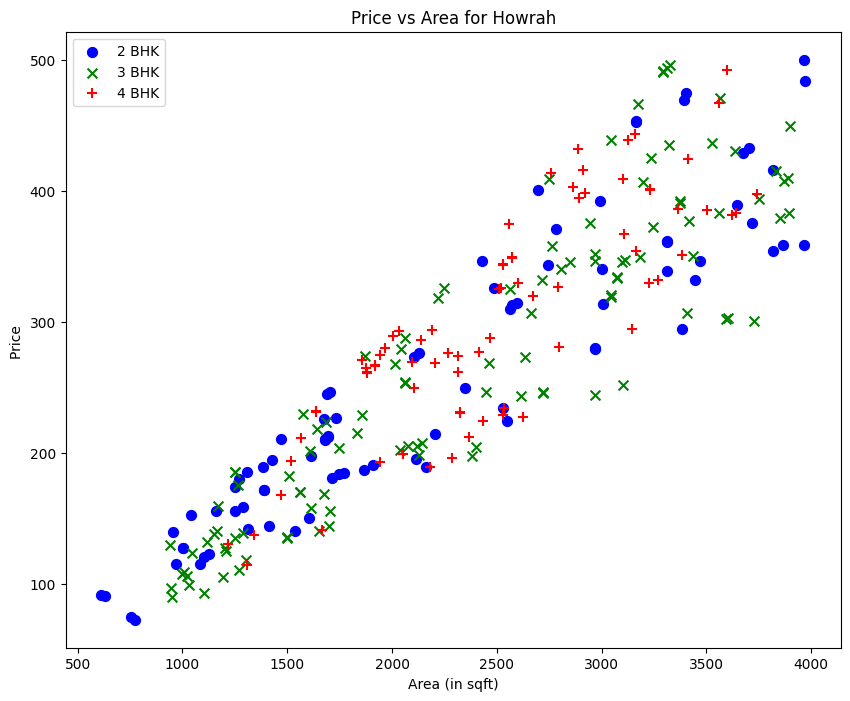

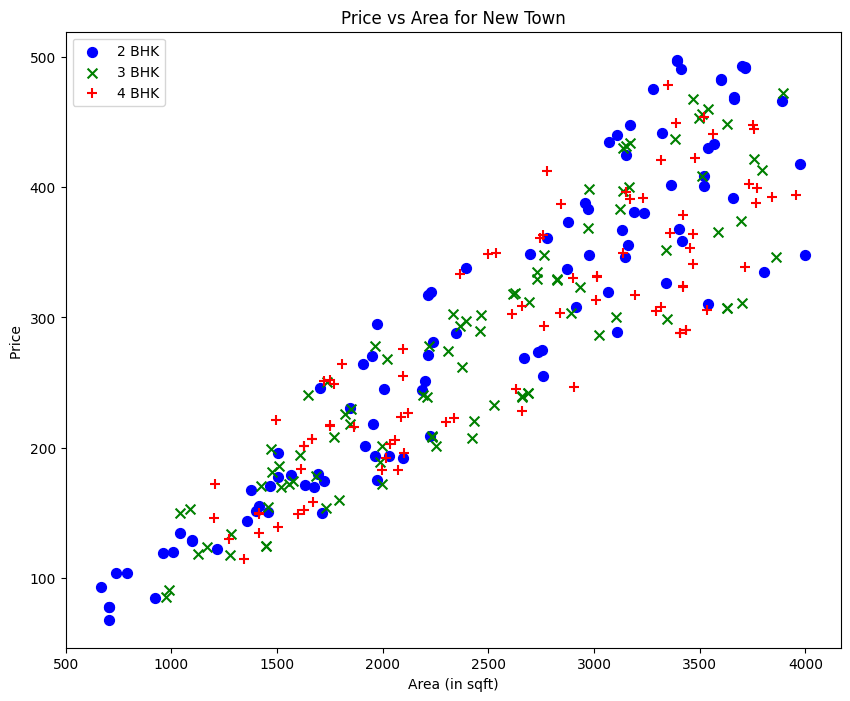

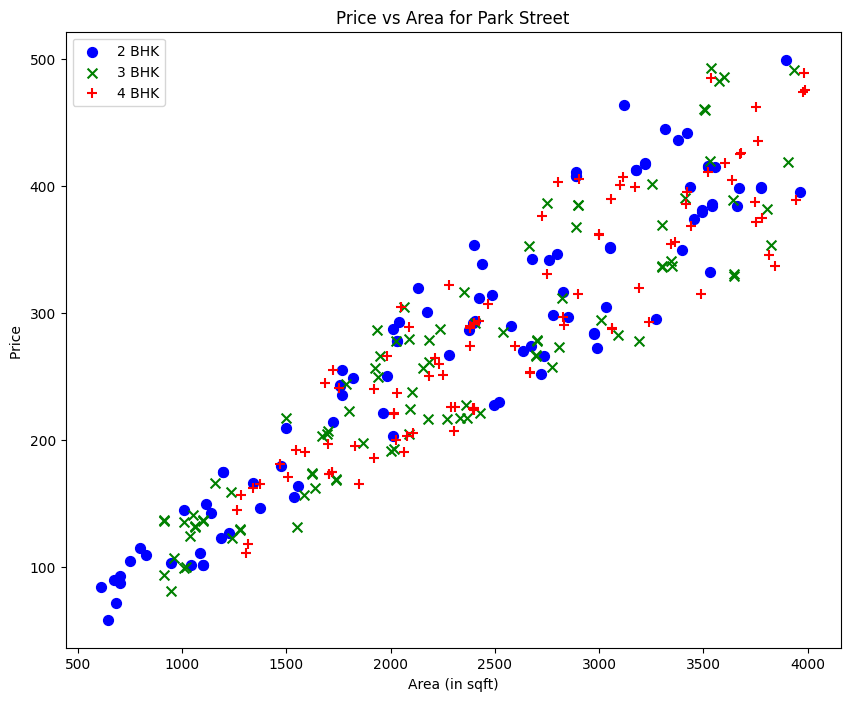

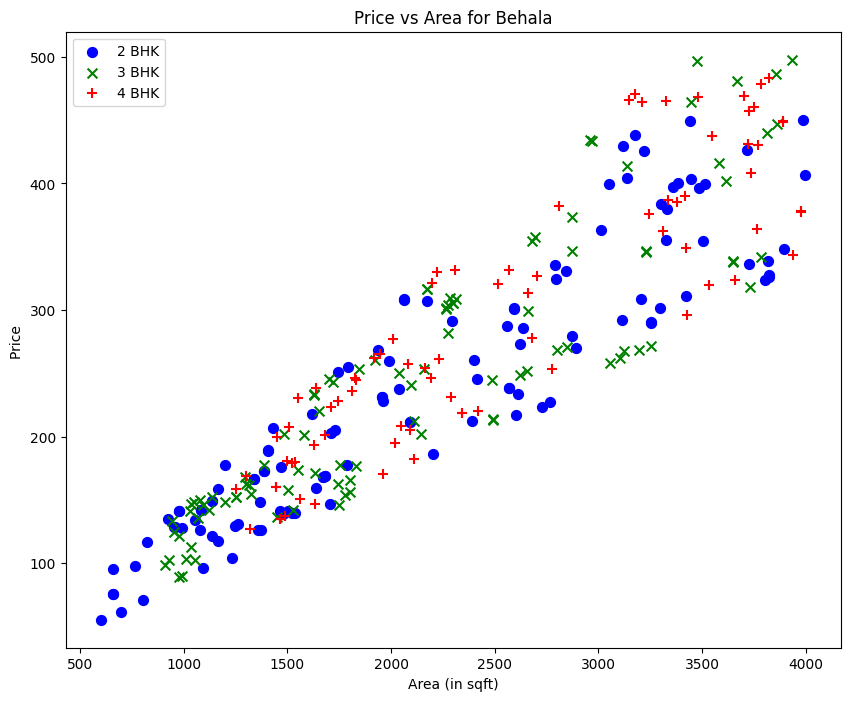

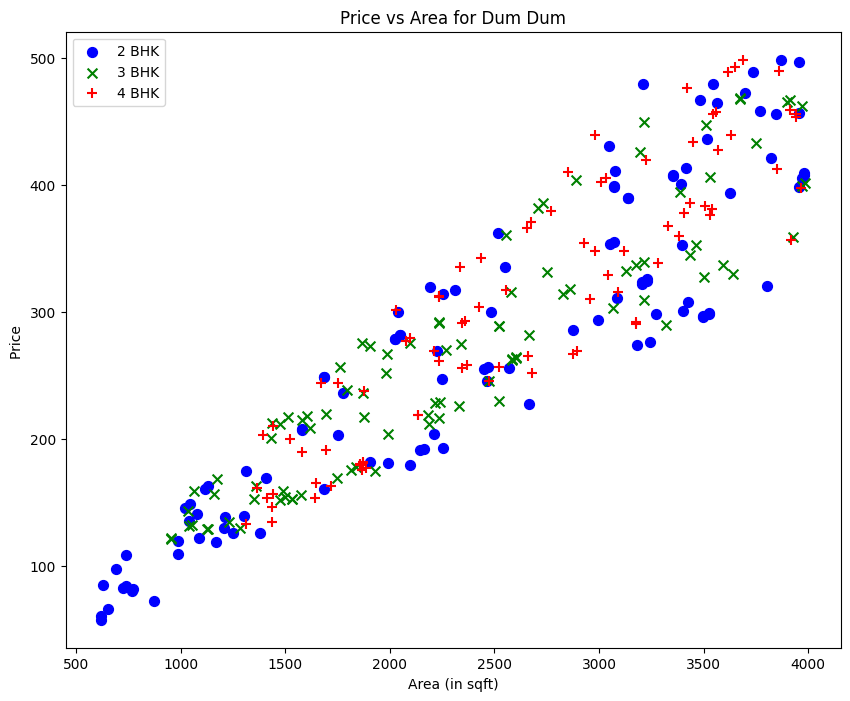

In [240]:
# for city in df6['LOCATION'].unique():
#     plot_scatter(df6, city)

plot_scatter(df7, 'Howrah')
plot_scatter(df7, 'New Town')
plot_scatter(df7, 'Park Street')
plot_scatter(df7, 'Behala')
plot_scatter(df7, 'Dum Dum')

In [241]:
df8 = df7.drop(['PRICE_PER_SQFT'], axis=1)
df8.head()

,BEDROOM_NUM,BATHROOM_NUM,AREA,LOCATION,AGE,BALCONY_NUM,AGE_BUCKET,TOTAL_PRICE
0,3.007367,2,3730.0,Alipore,0.0,1,New,382.47420
1,1.000000,2,1597.0,Alipore,0.0,3,New,227.01355
2,1.000000,2,1597.0,Alipore,0.0,3,New,227.18922
3,3.000000,2,3269.0,Alipore,21.0,1,Old,303.00361
4,3.007367,2,2496.0,Alipore,0.0,3,New,324.45504


In [242]:
location_stats = df5['LOCATION'].value_counts(ascending=False)
location_stats
# location_stats_less_than_10 = location_stats[location_stats<=20]
# location_stats_less_than_10

LOCATION
Others         4110
Tollygunge     1204
Ballygunge     1203
Park Street    1184
Dum Dum        1182
Salt Lake      1170
Behala         1167
Lake Town      1155
Howrah         1146
Kasba          1143
New Town       1136
Garia          1125
Jadavpur       1119
Alipore        1115
Rajarhat       1100
Name: count, dtype: int64

In [243]:
age_stats = df5['AGE_BUCKET'].value_counts(ascending=False)
age_stats

AGE_BUCKET
New        7276
Mid        5349
Old        5140
Mid New    2494
Name: count, dtype: int64

In [244]:
dummies_loc = pd.get_dummies(df8['LOCATION'], dtype='int')
dummies_age = pd.get_dummies(df8['AGE_BUCKET'], dtype='int')
dummies = pd.concat([dummies_loc, dummies_age], axis=1)
dummies.head()

,Alipore,Ballygunge,Behala,Dum Dum,Garia,Howrah,Jadavpur,Kasba,Lake Town,New Town,Others,Park Street,Rajarhat,Salt Lake,Tollygunge,New,Mid New,Mid,Old
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [245]:
df9 = pd.concat([df8, dummies.drop(['Howrah', 'Old'], axis=1)], axis=1)
df9.head()

,BEDROOM_NUM,BATHROOM_NUM,AREA,LOCATION,AGE,BALCONY_NUM,AGE_BUCKET,TOTAL_PRICE,Alipore,Ballygunge,...,Lake Town,New Town,Others,Park Street,Rajarhat,Salt Lake,Tollygunge,New,Mid New,Mid
0,3.007367,2,3730.0,Alipore,0.0,1,New,382.47420,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1.000000,2,1597.0,Alipore,0.0,3,New,227.01355,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.000000,2,1597.0,Alipore,0.0,3,New,227.18922,1,0,...,0,0,0,0,0,0,0,1,0,0
3,3.000000,2,3269.0,Alipore,21.0,1,Old,303.00361,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3.007367,2,2496.0,Alipore,0.0,3,New,324.45504,1,0,...,0,0,0,0,0,0,0,1,0,0


In [246]:
df10 = df9.drop(['LOCATION', 'AGE_BUCKET', 'AGE'], axis=1)
df10.head()

,BEDROOM_NUM,BATHROOM_NUM,AREA,BALCONY_NUM,TOTAL_PRICE,Alipore,Ballygunge,Behala,Dum Dum,Garia,...,Lake Town,New Town,Others,Park Street,Rajarhat,Salt Lake,Tollygunge,New,Mid New,Mid
0,3.007367,2,3730.0,1,382.47420,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.000000,2,1597.0,3,227.01355,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1.000000,2,1597.0,3,227.18922,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3.000000,2,3269.0,1,303.00361,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.007367,2,2496.0,3,324.45504,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [247]:
x = df10.drop(['TOTAL_PRICE'], axis=1)
y = df10['TOTAL_PRICE']

In [248]:
x.columns

Index(['BEDROOM_NUM', 'BATHROOM_NUM', 'AREA', 'BALCONY_NUM', 'Alipore',
       'Ballygunge', 'Behala', 'Dum Dum', 'Garia', 'Jadavpur', 'Kasba',
       'Lake Town', 'New Town', 'Others', 'Park Street', 'Rajarhat',
       'Salt Lake', 'Tollygunge', 'New', 'Mid New', 'Mid'],
      dtype='object')

In [249]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['FEATURES'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif_sorted = vif.sort_values(by='VIF', ascending=False)
vif_sorted[vif_sorted['VIF'] > 10]


,FEATURES,VIF


In [250]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
xgb_model = XGBRegressor(reg_alpha=0.3, reg_lambda=0.5, random_state=42)

xgb_model.fit(x_train, y_train)
xgb_model.score(x_test, y_test)

0.6093128533054861

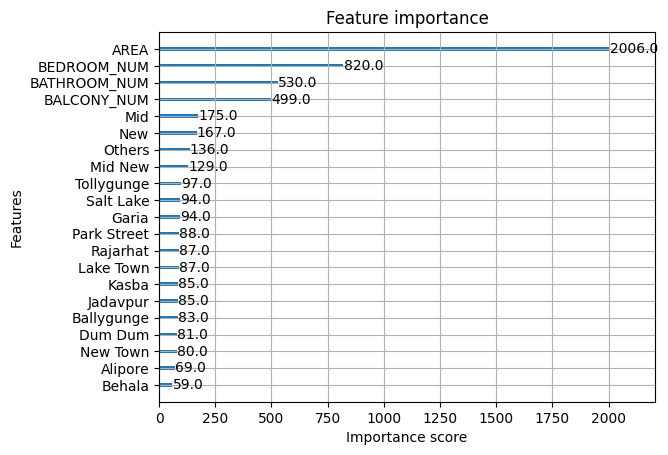

In [251]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model)
plt.show()

In [252]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

def get_best_model(algo, x, y):

    scores = []
    cv = ShuffleSplit(n_splits = 5, test_size=0.2, random_state=42)
    for model_name, config in algo.items():
        rs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        rs.fit(x, y)
        scores.append({
            'model': model_name,
            'best_score': rs.best_score_,
            'best_params': rs.best_params_
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params']).sort_values(by='best_score', ascending=False)

In [253]:
# algo1 = {
#         'XgbRegressor': {
#             'model': XGBRegressor(),
#             'params': {
#                 'n_estimators': [100, 200, 300],
#                 'max_depth': [4, 5, 6],
#                 'learning_rate': [0.01, 0.1, 0.2],
#                 'subsample': [0.6, 0.8, 1.0],
#                 'colsample_bytree': [0.6, 0.8, 1.0],
#                 'reg_alpha': [0.1, 0.5, 1],
#                 'reg_lambda': [0.5, 1, 2,] 
#             }
#         },
#         'LinearRegression': {
#             'model': LinearRegression(),
#             'params': {}
#         }
#     }

# get_best_model(algo1, x, y)['best_params'].values[0]

In [254]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return {
        'r2_score': r2,
        'mean_absolute_error': mae,
        'mean_squared_error': mse,
        'root_mean_squared_error': rmse
    }

evaluate_model(xgb_model, x_test, y_test)

{'r2_score': 0.6093128533054861,
 'mean_absolute_error': 58.05641651201707,
 'mean_squared_error': 5870.85850922634,
 'root_mean_squared_error': np.float64(76.62152771399393)}

OverFitting Check

In [255]:
best_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, reg_alpha=0.1, reg_lambda=2, subsample=0.8, colsample_bytree=1.0)

best_xgb.fit(x_train, y_train)
best_xgb.score(x_test, y_test)

0.625183678501443

In [256]:
from sklearn.metrics import r2_score

train_predicts = best_xgb.predict(x_train)
test_predicts = best_xgb.predict(x_test)

train_r2 = r2_score(y_train, train_predicts)
test_r2 = r2_score(y_test, test_predicts)

print(f"Train R2 Score: {train_r2}")
print(f"Test R2 Score: {test_r2}")

Train R2 Score: 0.7134432486841698
Test R2 Score: 0.625183678501443


In [257]:
from lightgbm import LGBMRegressor
model = LGBMRegressor()
model.fit(x_train, y_train)
model.score(x_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 11038, number of used features: 21
[LightGBM] [Info] Start training from score 235.706808


0.6244359565330773

In [258]:
def check_range_exists(value):
    if '-' in value:
        return True
    return False

def predict_price(bhk, area, location, age, bath, balcony):

    city_index = np.where(x.columns == location)[0][0]

    formatted_age = pd.cut([age], bins=[-1,5,10,20,30], labels=['New','Mid New','Mid','Old'])

    age_index = np.where(x.columns == formatted_age[0])[0][0]

    input1 = np.zeros(len(x.columns))

    # BEDROOM_NUM	BATHROOM_NUM	PRICE_PER_SQFT	AREA	AGE	BALCONY_NUM	

    input1[0] = bhk
    input1[1] = bath
    input1[2] = area
    input1[3] = balcony

    

    if city_index >= 0:
        input1[city_index] = 1

    if age_index >= 0:
        input1[age_index] = 1

    return best_xgb.predict([input1])[0]

In [259]:
predict_price(2, '600', 'Dum Dum', 1, 2, 1)

np.float32(83.74503)

In [260]:
import pickle
with open('../artifacts/house_predictor_citykol.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

In [261]:
with open('../artifacts/house_predictor_citykol.pkl', 'rb') as f:
    model_loaded = pickle.load(f)


In [ ]:
import json

columns = {'columns': [col.lower() for col in x.columns]}

with open('../common/columns_city.json', 'w') as f:
    json.dump(columns, f)